In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')

# Clean

Read the data

In [2]:
with open('ultimate_data_challenge.json') as f:
    raw_data = json.load(f)

df = pd.DataFrame(raw_data)
df.head(7)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4
5,10.56,5.0,3.5,1.00,Winterfell,2014-06-06,iPhone,2014-01-09,0.0,2,True,100.0
6,3.95,4.0,NaN,1.00,Astapor,2014-01-25,Android,2014-01-24,0.0,1,False,100.0


Inspect the data here we see null values in the following fields
- Rating by driver
- Rating of driver
- Phone type

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


Inspect the distribution of the data, following observations:
- Average distance is relatively symmterical with a long tail to the right
- Ratings of/by drivers are clustered near 5 making it a very asymmetrical distribution
- Surge percent and trips in first 30 days have exponential like distributions with so very high values but mostly very small values, we will inspect if there is a correlation between these variables
- Weekend percet similarly to the ratings fields are clustered asymmetrical leaning towards 100%

In [4]:
df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


Inspect the categorical fields
- Cateogries have a low cardinality, which is desirable for most algorithms

In [5]:
print(df['city'].unique())
print(df['phone'].unique())

["King's Landing" 'Astapor' 'Winterfell']
['iPhone' 'Android' None]


Fill in missing values
- Because the ratings fields are very asymmetrical we will fill the missing entries with the median of the column, this way we are assuming that having no rating get feels similar to having a common rating. In other words, dy default you have a 5 and only getting/giving a low rating influences the user
- Fill missing phone types with other, this creates a third category and allows us to keep data on IPhone vs Android clean without having to assume anything

In [6]:
df['phone'] = df['phone'].fillna('Other')
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].median())
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].median())

Convert strings to pandas Timestamps

In [7]:
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

Create new features for classifying active vs unactive accounts

In [8]:
df['days_since_trip'] = (df['last_trip_date'].sort_values().iloc[-1] - df['last_trip_date']).astype('timedelta64[D]')
df['active'] = df['days_since_trip'] <= 30

Using head and info methods we see the new fully cleaned data

In [9]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,days_since_trip,active
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,14.0,True
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,57.0,False
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,175.0,False
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,2.0,True
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,108.0,False


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
days_since_trip           50000 non-null float64
active                    50000 non-null bool
dtypes: bool(2), datetime64[ns](2), float64(7), int64(1), object(2)
memory usage: 4.7+ MB


# Explore

First we explore the relationships between the numeric fields by plotting their correlation values. We don't see much correlation except for the average surge and surge percent which are just different calculation of the same data, meaning this relationship is to be expected.

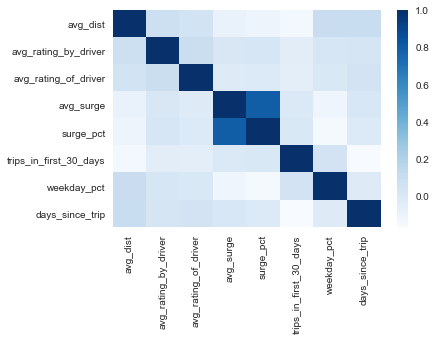

In [11]:
corr = df[['avg_dist','avg_rating_by_driver','avg_rating_of_driver','avg_surge','surge_pct', \
           'trips_in_first_30_days','weekday_pct','days_since_trip']].corr()

sns.heatmap(corr, cmap="Blues")

Next we look for any correlation between the day of sign up and the days since trip. We can see there is almost no correlation and the only cause of the very slight negative slope is only because earlier signups can have longer "days since trip" values. This is actually something that we wanted to show because now we can drop this column from the data when developing a model. In reality when the user signs up shouldn't matter (especially over such a short period of time) so it will only produce noise when developing the model.
<br><br>
Although the distribution of days since trip does seem interesting, it look bimodal with large and small "days since trip" values. We will investigate this next.
<br><br>
Note: We subsampled a very small percent of data (1%) in order to display a more interpretable graph

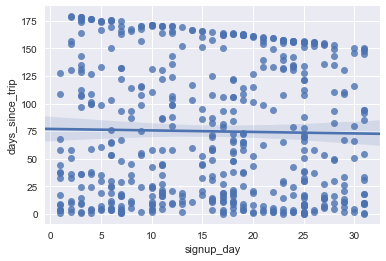

In [12]:
df['signup_day'] = df.signup_date.dt.day

_ = sns.regplot(x="signup_day", y="days_since_trip", data=df.sample(frac=.01))

When we view the distribution of the 'days since trip' field we see that the there are two peaks users that give rides very frequently and users that give a ride only a few times then never ride again. This could mean there is a certain type of customer that is very profitable for the business and targetting them could maximize the cost to reward ratio.

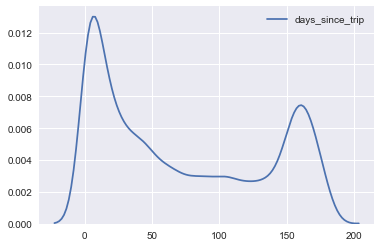

In [13]:
_ = sns.kdeplot(df['days_since_trip'])

Next we split the distribution into class for each city, we see that people from 'King's Landing' are much more likely to not return. Maybe offering people from there benefits and rewards would help them remain active while not unnecessarily losing profit by offering rewards to the other cities where they are likely to stay either way.

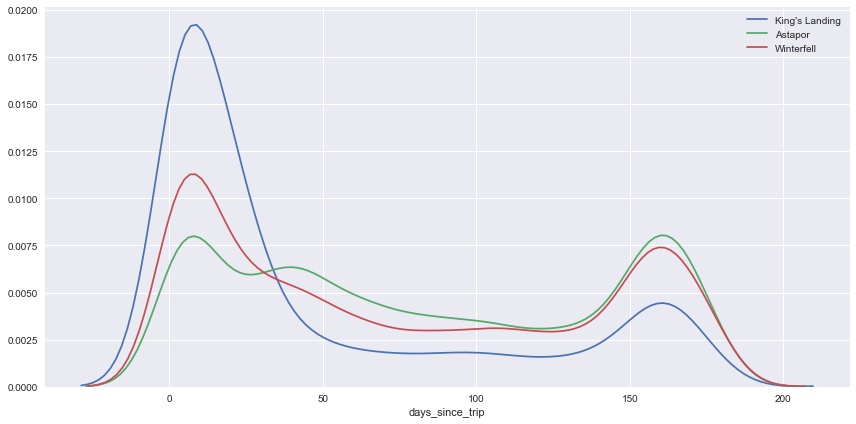

In [14]:
g = sns.FacetGrid(df[['city','days_since_trip']],hue='city',height=6,aspect=2)
g.map(sns.kdeplot, 'days_since_trip')

_ = plt.legend()

Finally we conduct a boostrap version of a hypothesis test to determine if the average retention rate differs for android and iphone users. We view the average retention rates for each, 40% active for iPhone and 21% for Android users. This is a large difference but could it be due to luck?

We assume not and act as if they come from the same Bernoulli distribution. We resample randomly many times and see how often a difference this large occurs in retention rate. Well..after 10,000 randomized trials no difference was this great..not even close. We graph the results showing that the mean never differed by more than 2.5% when they were treated equally while the true difference (in red) is 10 times further away! From this test we can be confident that iPhone users are more likely to continue using the application. Using this information we can apply the same methods mentioned above. Give necessary perks to Android users to help retain and while focusing sales and outreach towards iPhone users.

In [15]:
iphone_active = df[df['phone'] == 'iPhone'].loc[:,'active'].mean()
iphone_active

0.44893297090972184

In [16]:
android_active = df[df['phone'] == 'Android'].loc[:,'active'].mean()
android_active

0.2094261749434163

In [17]:
mean = iphone_active - android_active

split = len(df[df['phone'] == 'iPhone'].loc[:,'active'])

phone_test = df[df['phone'] != 'Other'].loc[:,'active']

means = []

for _ in range(10000):
    perm = phone_test.reindex(np.random.permutation(phone_test.index))
    means.append(perm[:split].mean() - perm[split:].mean())

means = pd.Series(means)
p_value = means[means >= mean].count() / len(means)
p_value

0.0

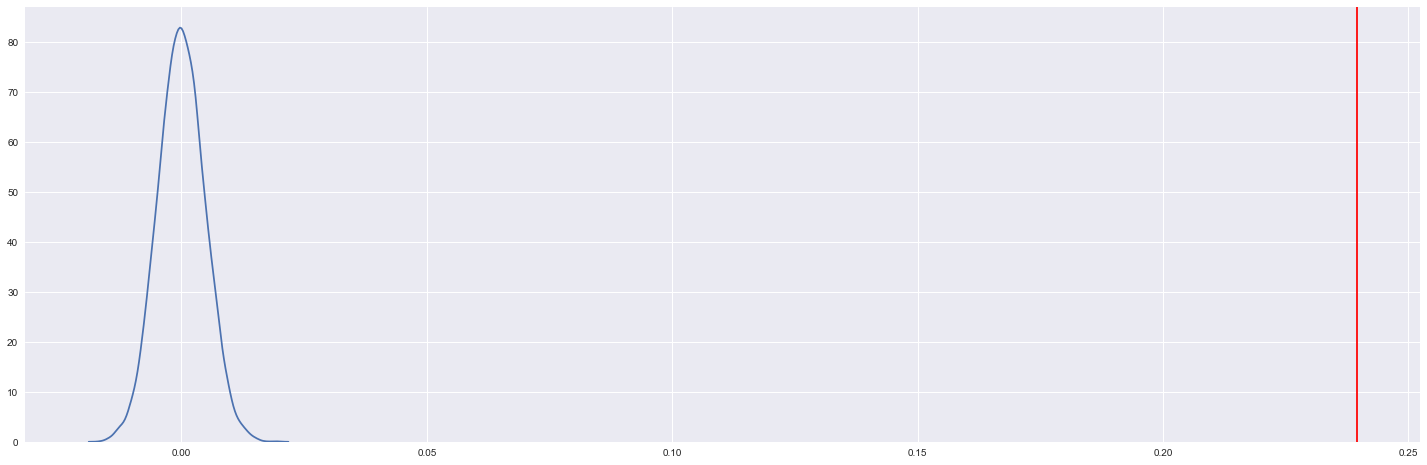

In [18]:
sns.kdeplot(means)
_ = plt.axvline(x=mean, color='red')

fig = plt.gcf()
fig.set_size_inches(25, 8)

# Model

Normalize the weights of the numeric columns to neutralize the impact of each column on the model

In [19]:
numeric = df[['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge','surge_pct', 'trips_in_first_30_days', 'weekday_pct']]
numeric.head(3)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
0,3.67,5.0,4.7,1.1,15.4,4,46.2
1,8.26,5.0,5.0,1.0,0.0,0,50.0
2,0.77,5.0,4.3,1.0,0.0,3,100.0


In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numeric_clean = pd.DataFrame(scaler.fit_transform(numeric),columns=numeric.columns)
numeric_clean.head(3)

C:\Users\Louie\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Louie\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
0,-0.372650,0.495437,0.086801,0.113506,0.328202,0.453984,-0.397131
1,0.431583,0.495437,0.608000,-0.336268,-0.443394,-0.600689,-0.294653
2,-0.880771,0.495437,-0.608132,-0.336268,-0.443394,0.190316,1.053741


Encode categorical variables into boolean columns, necessary for most algorithms

In [21]:
categorical = pd.get_dummies(df[['city','phone','ultimate_black_user','active']])
categorical['ultimate_black_user'] = categorical['ultimate_black_user'].astype(int)
categorical['active'] = categorical['active'].astype(int)
categorical.head(3)

,ultimate_black_user,active,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_Other,phone_iPhone
0,1,1,0,1,0,0,0,1
1,0,0,1,0,0,1,0,0
2,0,0,1,0,0,0,0,1


Aggregate data into final clean dataset

In [22]:
clean_final = pd.concat([numeric_clean,categorical], axis=1)[['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'trips_in_first_30_days', 'weekday_pct',
       'ultimate_black_user', 'city_Astapor', 'city_King\'s Landing',
       'city_Winterfell', 'phone_Android', 'phone_Other', 'phone_iPhone','active']]
clean_final.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,ultimate_black_user,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_Other,phone_iPhone,active
0,-0.372650,0.495437,0.086801,0.113506,0.328202,0.453984,-0.397131,1,0,1,0,0,0,1,1
1,0.431583,0.495437,0.608000,-0.336268,-0.443394,-0.600689,-0.294653,0,1,0,0,1,0,0,0
2,-0.880771,0.495437,-0.608132,-0.336268,-0.443394,0.190316,1.053741,0,1,0,0,0,0,1,0
3,-0.602181,0.271207,-0.086933,0.293416,0.558679,1.772325,0.514383,1,0,1,0,0,0,1,1
4,-0.467266,0.271207,-0.434399,0.518303,0.147829,3.090665,0.579106,0,0,0,1,1,0,0,0


#### Splitting
Split the data into train and test sections

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(clean_final.iloc[:,:-1], clean_final.iloc[:,-1], test_size=0.25)

#### Training
Next train a logistic regression model using a grid search validated by cross fold validation. Here we use the F1 scoring metric because the active class is relatively rare (about 1/3 of all data). We do two rounds of grid search to close in on the optimal hyperparameter and the overall best model.

In [35]:
clean_final.iloc[:,-1].mean()

0.37608

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

grid={"C":np.logspace(-3,3,7)}
logreg=LogisticRegression(solver='lbfgs')
logreg_cv=GridSearchCV(logreg,grid,cv=10,scoring='f1')
logreg_cv.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [39]:
logreg_cv.best_score_

0.5694188096719109

In [40]:
logreg_cv.best_params_

{'C': 10.0}

In [43]:
grid={"C":np.linspace(1,100,50)}
logreg=LogisticRegression(solver='lbfgs')
logreg_cv=GridSearchCV(logreg,grid,cv=10,scoring='f1')
logreg_cv.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([  1.     ,   3.02041,   5.04082,   7.06122,   9.08163,  11.10204,
        13.12245,  15.14286,  17.16327,  19.18367,  21.20408,  23.22449,
        25.2449 ,  27.26531,  29.28571,  31.30612,  33.32653,  35.34694,
        37.36735,  39.38776,  41.40816,  43.42857,  45.44898,  4...     85.85714,  87.87755,  89.89796,  91.91837,  93.93878,  95.95918,
        97.97959, 100.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [44]:
logreg_cv.best_score_

0.5694188096719109

In [45]:
logreg_cv.best_params_

{'C': 3.020408163265306}

#### Evaluating
Once the model is fit we evaluate it using accuracy, ROC curve, and a confusion matrix.
- Accuracy is about 72%, but this could be misleading as always guessing 'Inactive' will give you 63%. This is why the confusion matrix is important
- ROC curve shows normal behaviour
- In the confusion matrix we can see that the model is predicting mostly inactive and is much more likely to guess an inactive that is active verses guessing an active that is inactive. This is a normal outcome for uneven datasets. Using cost benefit analysis we can adjust the model to have less false_negatives for more true_positives and more false_positives, but this dependent on the value added/lost for each category.

In [56]:
final_clf = logreg_cv.best_estimator_
preds = final_clf.predict(X_test)
probs = pd.DataFrame(final_clf.predict_proba(X_test)).iloc[:,0]

In [62]:
final_clf.score(X_test,y_test) * 100

72.21600000000001

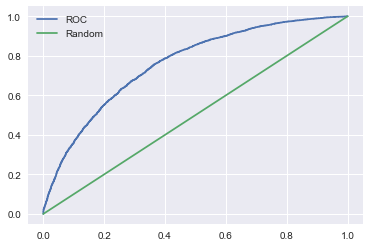

In [61]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)
plt.plot(tpr,fpr,label='ROC')
plt.plot(np.linspace(0,1,500),np.linspace(0,1,500),label='Random')

_ = plt.legend()

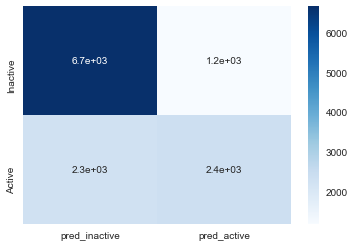

In [73]:
from sklearn.metrics import confusion_matrix
conf_matrix = pd.DataFrame(confusion_matrix(y_test, preds),columns=['pred_inactive','pred_active'], index=['Inactive','Active'])

sns.heatmap(conf_matrix, annot=True, cmap="Blues")

#### Interpretting
Finally we analyze the model to see what information we can get from the model. We can see from below that all things held constant the app has a 35% retention rate

In [98]:
1 / (1 + np.exp(-1 * (final_clf.intercept_)))[0] * 100

35.551697601335874

First we'll look at the numeric categories. Here we see that many of the categories seem to have little impact to the user remaining active. However 'trips in the first 30 days' and 'average distance' are by far the strongest predictors. 
<br><br>
Based off of this finding ways to get the user to get in the habit of using the app may help. Because this connection may be caused by a confounding variable (remaining active and using in the first 30 days is caused by something else instead of 30 day use causing retention) we can retrain models after trips in first 30 days increase and see if it is still as strong of a predictor. Also finding ways of decreasing driver times may help retention.

In [94]:
coefs = pd.Series(final_clf.coef_[0], index=clean_final.iloc[:,:-1].columns)
coefs[:7]

avg_dist                 -0.207834
avg_rating_by_driver     -0.066965
avg_rating_of_driver     -0.068435
avg_surge                -0.050383
surge_pct                 0.080836
trips_in_first_30_days    0.465037
weekday_pct              -0.009704
dtype: float64

Finally we look at the categorical variables and see the probability of the user remaining active given just that category. We see that King's landing, using an iPhone and being an ultimate black user and the most influential category for retaining users. Because of this I would recommend focusing marketing towards these users. Also it may be beneficial to low costs to the user for becoming a black member to try and get more of these members since becoming a member has a great retention benefit.

In [93]:
probs = 1 / (1 + np.exp(-1 * (coefs + final_clf.intercept_)))
probs[7:]

ultimate_black_user    0.565911
city_Astapor           0.176144
city_King's Landing    0.547689
city_Winterfell        0.264041
phone_Android          0.210458
phone_Other            0.303879
phone_iPhone           0.443896
dtype: float64